In [1]:
from gptopt.optim.pdhg import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )  
\end{aligned}
$$


In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 200

betas = [ 1e-3, 5e-4, 1e-4]

#  $m=n=50$

In [39]:
m = n = 50
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=1, std2=1, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)
beta = 1

mu_reg = 0
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=6.9660e+01


In [40]:
Z_star_1, Z_star_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, mu=mu_reg, verbose=False)

In [41]:
Y_star_torch = torch.tensor(Y_star, dtype=A.dtype, device=device)
Z_star_1_torch = torch.tensor(Z_star_1, dtype=A.dtype, device=device)
Z_star_2_torch = torch.tensor(Z_star_2, dtype=A.dtype, device=device)
pd_residuals_infty_ball(A, B, Y_star_torch, Z_star_1_torch, Z_star_2_torch, G1, G2, beta, mu_reg, abs_tol=1e-4)

(1.820577926991973e-05,
 3.640791774806465e-07,
 1.45687814512247e-06,
 1.1663573555208136e-07)

In [46]:
Y0, res_y = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=1000) 
(Z1_0, Z2_0), res_z = attn_least_squares_solve(A1=B, A2=A, G1=G1, G2=G2, X_type="Z", Y0=Y0, beta=beta, 
                                                tol=1e-10, maxit=1000, diag_scaling=True)
res_y["res"], res_z["res"]

(1.1784385096024251e-06, 1.3478992332238703e-06)

In [43]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [33]:
func_obj = lambda Z1, Z2: (torch.trace(G1.T @ Z1) + torch.trace(G2.T @ Z2)).item()  
func_constr_viol = lambda Z1, Z2: max(torch.max(torch.abs(Z1.T @ B + A.T @ Z2)).item() - beta, 0) / beta

In [34]:
print(
    f"{f_star=}, "
    f"{func_obj(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}"
)

f_star=np.float64(-50.525435814078094), -50.52543640136719, 
cvxpy constraint violation: 9.5367431640625e-07


In [36]:
residuals = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=f_star, 
                            stopping=False, max_iter=1000, eps_abs=1e-5)

lamb_max=70.01979168217345
lamb_max=70.01979168217345
lamb_max=70.01979168217345
lamb_max=70.01979168217345
lamb_max=70.01979168217345
lamb_max=70.01979168217345
lamb_max=70.01979168217345
Method                 Obj          Viol
----------------------------------------
PDHG          -5.013597e+01  2.516842e-02
PDHG DS       -5.031345e+01  9.242177e-03
PDHG Acc      -5.013597e+01  2.516842e-02
HPDHG DS      -5.020633e+01  1.333952e-02
reHPDHG DS    -5.036746e+01  4.426003e-03
HPDHG         -5.020633e+01  1.333952e-02
reHPDHG       -5.018716e+01  5.630016e-03


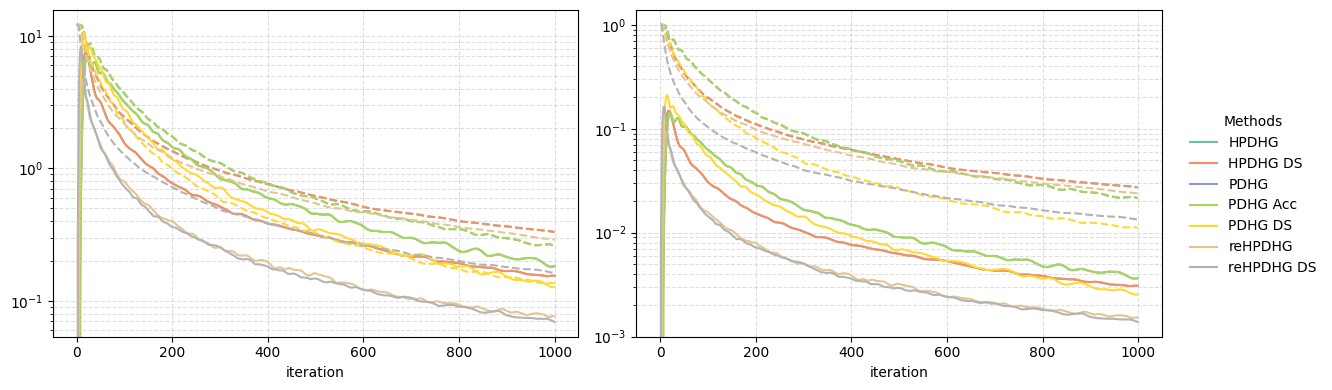

In [37]:
plot_residuals_compare(residuals, dpi=100, dual_scale=True,
                    #    abs_ylim=(1e-3, 1e-1), rel_ylim=(1e-3, 2)
                       )

#  $m=n=1000$

In [12]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)

lamb_max = (A.pow(2).sum().sqrt().item() + B.pow(2).sum().sqrt().item()) ** 0.5

print(f"{lamb_max=:.4e}")

lamb_max=3.7619e+00


In [13]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}")
    residuals[beta] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-6)

beta=0.001, lamb_max=3.7619e+00
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
Method                 Obj          Viol
----------------------------------------
PDHG          -8.190031e-01  1.173229e+00
PDHG DS       -1.018616e+00  1.776846e+00
PDHG Acc      -8.190031e-01  1.173229e+00
HPDHG DS      -9.601523e-01  5.760449e-01
reHPDHG DS    -9.729699e-01  2.681929e-01
HPDHG         -9.601523e-01  5.760449e-01
reHPDHG       -9.210459e-01  2.754310e-01
beta=0.0005, lamb_max=3.7619e+00
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
lamb_max=10.007087425088692
Method                 Obj          Viol
----------------------------------------
PDHG          -4.740272e-01  2.574898e+00
PDHG DS       -5.333171e-01  3.003409e+00
P

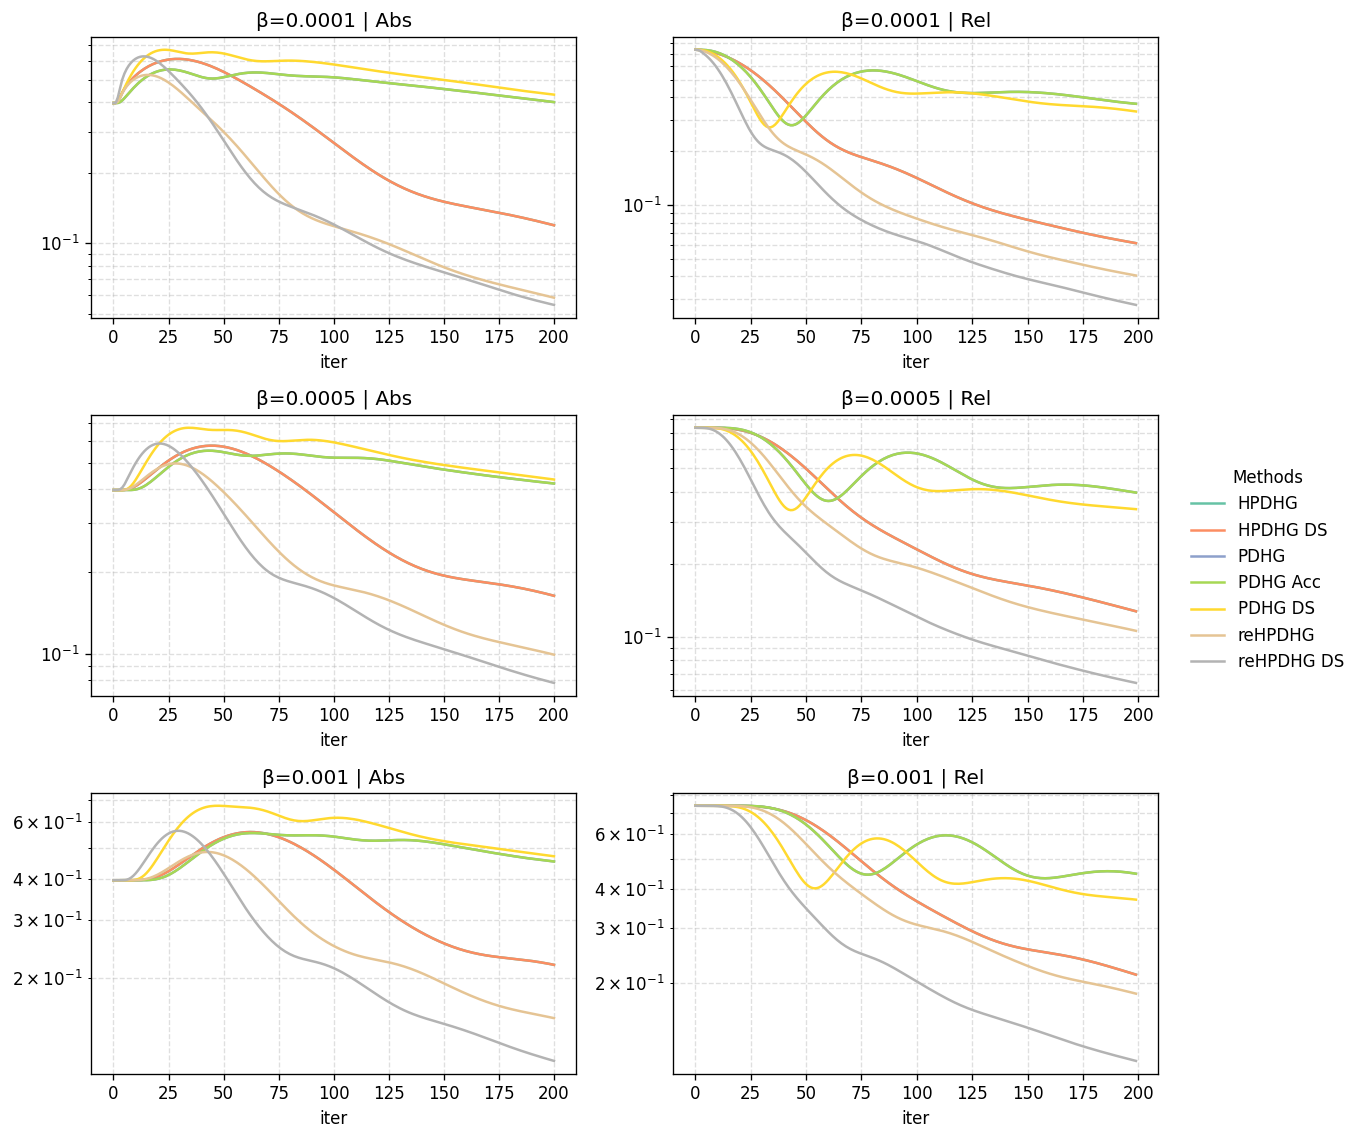

In [14]:
_ = plot_residuals_grid_by_param(residuals, 
                                #  abs_ylim=(1e-3, 5), rel_ylim=(1e-4, 1.5), 
                                 param_name='beta')

#  $m=n=1000$

In [15]:
m = n = 1000
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)


nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}")

mu_reg=0.0000e+00, lamb_max=9.9972e+00


In [16]:
residuals = {}
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()
 
    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}")
    residuals[beta] = compare_methods(prox_h_conj, h_conj, lamb_max, A, B, G1, G2, beta, mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-6)

beta=0.001, lamb_max=9.9972e+00
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
Method                 Obj          Viol
----------------------------------------
PDHG          -3.108827e-02  2.121686e-01
PDHG DS       -5.205247e-02  2.078953e-01
PDHG Acc      -3.108827e-02  2.121686e-01
HPDHG DS      -2.835664e-02  1.631114e-01
reHPDHG DS    -5.207699e-02  1.028764e-01
HPDHG         -2.835664e-02  1.631114e-01
reHPDHG       -3.198604e-02  9.536806e-02
beta=0.0005, lamb_max=9.9972e+00
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
lamb_max=9.997217356568438
Method                 Obj          Viol
----------------------------------------
PDHG          -2.871694e-02  2.884571e-01
PDHG DS       -3.467751e-02  3.568471e-01
PDHG Acc      -

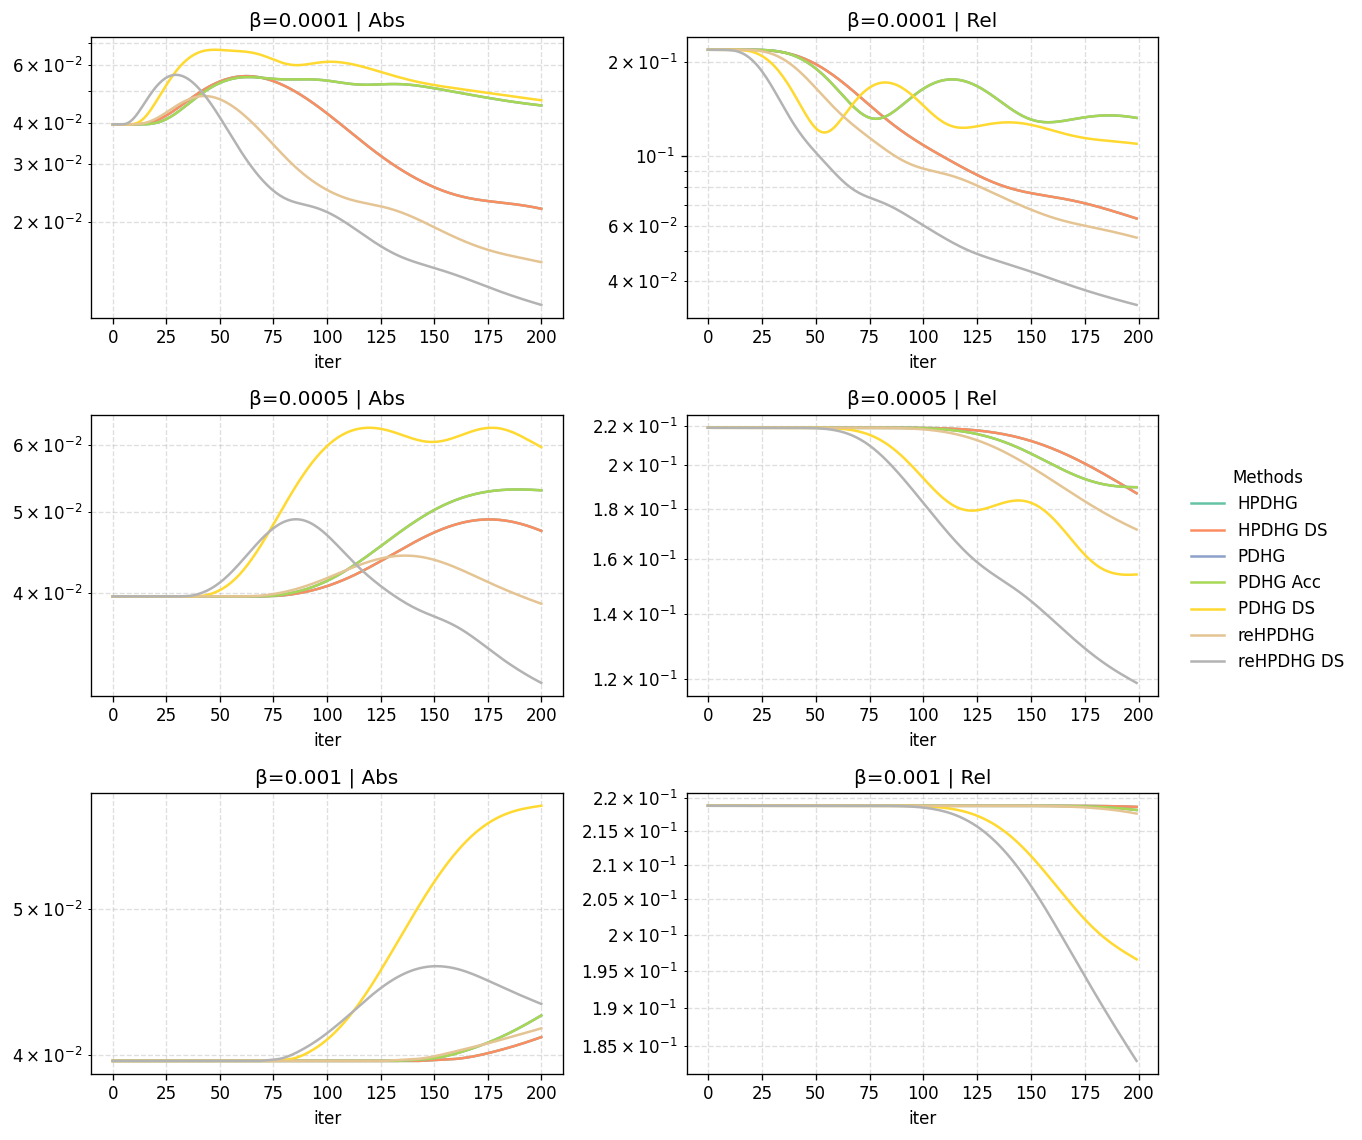

In [17]:
_ = plot_residuals_grid_by_param(residuals,  param_name='beta')

In [18]:
import numpy as np
import scipy.sparse as sp
from cupdlpx import Model


def cupdlpx_AB(G1, G2, A, B, beta, verbose=False):
    """
    Solves the same LP as:

      min  <G1,Z1> + <G2,Z2>
      s.t. Z1^T B + A^T Z2 == X
           -beta <= X <= beta     (elementwise)

    using cuPDLPx (cupdlpx) in bound form:  l <= M v <= u,  lb <= v <= ub.

    Returns: Z1, Z2, obj, Y
      - Z1: (m,n)
      - Z2: (m,k)
      - obj: scalar
      - Y:  (n,k) dual for the equality constraints (in cupdlpx order='F')
            (may differ by a sign from CVXPY depending on convention).
    """
    # --- numpy + shapes ---
    G1 = np.asarray(G1, dtype=np.float64)
    G2 = np.asarray(G2, dtype=np.float64)
    A  = np.asarray(A,  dtype=np.float64)
    B  = np.asarray(B,  dtype=np.float64)

    m, n = A.shape
    m2, k = B.shape
    if m2 != m:
        raise ValueError(f"A is {A.shape}, B is {B.shape}; must share row dimension m.")
    if G1.shape != (m, n) or G2.shape != (m, k):
        raise ValueError(f"G1 must be {(m,n)}, G2 must be {(m,k)}; got {G1.shape}, {G2.shape}.")

    beta_arr = np.asarray(beta, dtype=np.float64)
    if beta_arr.ndim == 0:
        beta_mat = np.full((n, k), float(beta_arr), dtype=np.float64)
    else:
        beta_mat = np.broadcast_to(beta_arr, (n, k)).astype(np.float64, copy=False)

    # --- variable vector v = [u; v; w] ---
    # u = vec(Z1^T)  (n*m)
    # v = vec(Z2)    (m*k)
    # w = vec(X)     (n*k)
    nu, nv, nw = n * m, m * k, n * k
    N = nu + nv + nw

    # --- objective c^T v ---
    c_u = (G1.T).reshape(-1, order="F")          # vec(G1^T) matches vec(Z1^T)
    c_v = G2.reshape(-1, order="F")              # vec(G2)   matches vec(Z2)
    c_w = np.zeros(nw, dtype=np.float64)         # X not in objective
    c = np.concatenate([c_u, c_v, c_w])

    # --- equality constraints: (B^T ⊗ I_n) vec(Z1^T) + (I_k ⊗ A^T) vec(Z2) - vec(X) = 0 ---
    Bt  = sp.csr_matrix(B.T)                     # (k,m)
    At  = sp.csr_matrix(A.T)                     # (n,m)
    In  = sp.eye(n, format="csr")
    Ik  = sp.eye(k, format="csr")
    Ink = sp.eye(n * k, format="csr")

    M1 = sp.kron(Bt, In, format="csr")           # (n*k, n*m)
    M2 = sp.kron(Ik, At, format="csr")           # (n*k, m*k)
    Aeq = sp.hstack([M1, M2, -Ink], format="csr")# (n*k, N)

    l = np.zeros(nk := n * k, dtype=np.float64)
    u = np.zeros(nk, dtype=np.float64)

    # --- variable bounds: Z1,Z2 free; X bounded in [-beta, beta] ---
    lb = np.full(N, -np.inf, dtype=np.float64)
    ub = np.full(N,  np.inf, dtype=np.float64)

    beta_vec = beta_mat.reshape(-1, order="F")   # matches vec(X) order='F'
    lb[nu + nv : nu + nv + nw] = -beta_vec
    ub[nu + nv : nu + nv + nw] =  beta_vec

    # --- solve ---
    model = Model(c, Aeq, l, u, lb, ub)
    if not verbose:
        # if your cupdlpx build supports it, you can silence output like:
        # model.setParams(OutputFlag=False)
        pass

    model.optimize()

    x = np.asarray(model.X, dtype=np.float64)    # primal vector v
    pi = np.asarray(model.Pi, dtype=np.float64)  # dual for constraints l<=Aeq v<=u (here equalities)

    # --- unpack ---
    u_sol = x[:nu]
    v_sol = x[nu:nu + nv]
    w_sol = x[nu + nv:]

    Z1t = u_sol.reshape((n, m), order="F")
    Z1  = Z1t.T                                  # (m,n)

    Z2  = v_sol.reshape((m, k), order="F")       # (m,k)
    # X   = w_sol.reshape((n, k), order="F")      # (n,k) if you need it

    obj = float(getattr(model, "ObjVal", c @ x))
    Y   = pi.reshape((n, k), order="F")          # dual for the equality constraints

    return Z1, Z2, obj, Y


ImportError: /mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/cupdlpx/_cupdlpx_core.cpython-311-x86_64-linux-gnu.so: undefined symbol: _ZNSt15__exception_ptr13exception_ptr10_M_releaseEv

In [ ]:
Z_star_1, Z_star_2, f_star, Y_star = cupdlpx_AB(G1_np, G2_np, A_np, B_np, beta, verbose=True)

In [ ]:
f_star

-0.00025147007652368914

In [ ]:
pd_residuals_infty_ball(A, B, Y_star, Z_star_1, Z_star_2, G1, G2, beta, abs_tol=1e-4)